In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import argparse
import datetime
import os
from tensorboardX import SummaryWriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = models.vgg13(pretrained=True)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) 
        features = self.pretrained_model.features(x)
        pooled_features = self.pooling_layer(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
        output = self.classifer(flattened_features)
        return output

In [2]:
cnn_name="VGG13"
injury_type="acl"
mri_view="coronal"
injury_name=injury_type.capitalize()+"_Tear"

In [3]:
class MRDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        label = torch.FloatTensor([label])
        
        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            array = torch.FloatTensor(array)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)
        return array, label, weight

In [4]:
def th_iterproduct(*args):
    return torch.from_numpy(np.indices(args).reshape((len(args),-1)).T)

def th_affine2d(x, matrix, mode='bilinear', center=True):
    """
    2D Affine image transform on torch.Tensor
    
    Arguments
    ---------
    x : torch.Tensor of size (C, H, W)
        image tensor to be transformed
    matrix : torch.Tensor of size (3, 3) or (2, 3)
        transformation matrix
    mode : string in {'nearest', 'bilinear'}
        interpolation scheme to use
    center : boolean
        whether to alter the bias of the transform 
        so the transform is applied about the center
        of the image rather than the origin
    Example
    ------- 
    >>> import torch
    >>> from torchsample.utils import *
    >>> x = torch.zeros(2,1000,1000)
    >>> x[:,100:1500,100:500] = 10
    >>> matrix = torch.FloatTensor([[1.,0,-50],
    ...                             [0,1.,-50]])
    >>> xn = th_affine2d(x, matrix, mode='nearest')
    >>> xb = th_affine2d(x, matrix, mode='bilinear')
    """

    if matrix.dim() == 2:
        matrix = matrix[:2,:]
        matrix = matrix.unsqueeze(0)
    elif matrix.dim() == 3:
        if matrix.size()[1:] == (3,3):
            matrix = matrix[:,:2,:]

    A_batch = matrix[:,:,:2]
    if A_batch.size(0) != x.size(0):
        A_batch = A_batch.repeat(x.size(0),1,1)
    b_batch = matrix[:,:,2].unsqueeze(1)

    # make a meshgrid of normal coordinates
    _coords = th_iterproduct(x.size(1),x.size(2))
    coords = _coords.unsqueeze(0).repeat(x.size(0),1,1).float()

    if center:
        # shift the coordinates so center is the origin
        coords[:,:,0] = coords[:,:,0] - (x.size(1) / 2. - 0.5)
        coords[:,:,1] = coords[:,:,1] - (x.size(2) / 2. - 0.5)
    # apply the coordinate transformation
    new_coords = coords.bmm(A_batch.transpose(1,2)) + b_batch.expand_as(coords)

    if center:
        # shift the coordinates back so origin is origin
        new_coords[:,:,0] = new_coords[:,:,0] + (x.size(1) / 2. - 0.5)
        new_coords[:,:,1] = new_coords[:,:,1] + (x.size(2) / 2. - 0.5)

    # map new coordinates using bilinear interpolation
    if mode == 'nearest':
        x_transformed = th_nearest_interp2d(x.contiguous(), new_coords)
    elif mode == 'bilinear':
        x_transformed = th_bilinear_interp2d(x.contiguous(), new_coords)

    return x_transformed
def th_random_choice(a, n_samples=1, replace=True, p=None):
    """
    Parameters
    -----------
    a : 1-D array-like
        If a torch.Tensor, a random sample is generated from its elements.
        If an int, the random sample is generated as if a was torch.range(n)
    n_samples : int, optional
        Number of samples to draw. Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement
    p : 1-D array-like, optional
        The probabilities associated with each entry in a.
        If not given the sample assumes a uniform distribution over all
        entries in a.
    Returns
    --------
    samples : 1-D ndarray, shape (size,)
        The generated random samples
    """
    if isinstance(a, int):
        a = torch.arange(0, a)

    if p is None:
        if replace:
            idx = torch.floor(torch.rand(n_samples)*a.size(0)).long()
        else:
            idx = torch.randperm(len(a))[:n_samples]
    else:
        if abs(1.0-sum(p)) > 1e-3:
            raise ValueError('p must sum to 1.0')
        if not replace:
            raise ValueError('replace must equal true if probabilities given')
        idx_vec = torch.cat([torch.zeros(round(p[i]*1000))+i for i in range(len(p))])
        idx = (torch.floor(torch.rand(n_samples)*999)).long()
        idx = idx_vec[idx].long()
    selection = a[idx]
    if n_samples == 1:
        selection = selection[0]
    return selection
def th_bilinear_interp2d(input, coords):
    """
    bilinear interpolation in 2d
    """
    x = torch.clamp(coords[:,:,0], 0, input.size(1)-2)
    x0 = x.floor()
    x1 = x0 + 1
    y = torch.clamp(coords[:,:,1], 0, input.size(2)-2)
    y0 = y.floor()
    y1 = y0 + 1

    stride = torch.LongTensor(input.stride())
    x0_ix = x0.mul(stride[1]).long()
    x1_ix = x1.mul(stride[1]).long()
    y0_ix = y0.mul(stride[2]).long()
    y1_ix = y1.mul(stride[2]).long()

    input_flat = input.view(input.size(0),-1)

    vals_00 = input_flat.gather(1, x0_ix.add(y0_ix))
    vals_10 = input_flat.gather(1, x1_ix.add(y0_ix))
    vals_01 = input_flat.gather(1, x0_ix.add(y1_ix))
    vals_11 = input_flat.gather(1, x1_ix.add(y1_ix))
    
    xd = x - x0
    yd = y - y0
    xm = 1 - xd
    ym = 1 - yd

    x_mapped = (vals_00.mul(xm).mul(ym) +
                vals_10.mul(xd).mul(ym) +
                vals_01.mul(xm).mul(yd) +
                vals_11.mul(xd).mul(yd))

    return x_mapped.view_as(input)
class Rotate(object):

    def __init__(self, 
                 value,
                 interp='bilinear',
                 lazy=False):
        """
        Randomly rotate an image between (-degrees, degrees). If the image
        has multiple channels, the same rotation will be applied to each channel.
        Arguments
        ---------
        rotation_range : integer or float
            image will be rotated between (-degrees, degrees) degrees
        interp : string in {'bilinear', 'nearest'} or list of strings
            type of interpolation to use. You can provide a different
            type of interpolation for each input, e.g. if you have two
            inputs then you can say `interp=['bilinear','nearest']
        lazy    : boolean
            if true, only create the affine transform matrix and return that
            if false, perform the transform on the tensor and return the tensor
        """
        self.value = value
        self.interp = interp
        self.lazy = lazy

    def __call__(self, *inputs):
        if not isinstance(self.interp, (tuple,list)):
            interp = [self.interp]*len(inputs)
        else:
            interp = self.interp

        theta = math.pi / 180 * self.value
        rotation_matrix = torch.FloatTensor([[math.cos(theta), -math.sin(theta), 0],
                                          [math.sin(theta), math.cos(theta), 0],
                                          [0, 0, 1]])
        if self.lazy:
            return rotation_matrix
        else:
            outputs = []
            for idx, _input in enumerate(inputs):
                input_tf = th_affine2d(_input,
                                       rotation_matrix,
                                       mode=interp[idx],
                                       center=True)
                outputs.append(input_tf)
            return outputs if idx > 1 else outputs[0]
class Translate(object):

    def __init__(self, 
                 value, 
                 interp='bilinear',
                 lazy=False):
        """
        Arguments
        ---------
        value : float or 2-tuple of float
            if single value, both horizontal and vertical translation
            will be this value * total height/width. Thus, value should
            be a fraction of total height/width with range (-1, 1)
        interp : string in {'bilinear', 'nearest'} or list of strings
            type of interpolation to use. You can provide a different
            type of interpolation for each input, e.g. if you have two
            inputs then you can say `interp=['bilinear','nearest']
        """
        if not isinstance(value, (tuple,list)):
            value = (value, value)

        if value[0] > 1 or value[0] < -1:
            raise ValueError('Translation must be between -1 and 1')
        if value[1] > 1 or value[1] < -1:
            raise ValueError('Translation must be between -1 and 1')

        self.height_range = value[0]
        self.width_range = value[1]
        self.interp = interp
        self.lazy = lazy

    def __call__(self, *inputs):
        if not isinstance(self.interp, (tuple,list)):
            interp = [self.interp]*len(inputs)
        else:
            interp = self.interp

        tx = self.height_range * inputs[0].size(1)
        ty = self.width_range * inputs[0].size(2)

        translation_matrix = torch.FloatTensor([[1, 0, tx],
                                             [0, 1, ty],
                                             [0, 0, 1]])
        if self.lazy:
            return translation_matrix
        else:
            outputs = []
            for idx, _input in enumerate(inputs):
                input_tf = th_affine2d(_input,
                                       translation_matrix,
                                       mode=interp[idx],
                                       center=True)
                outputs.append(input_tf)
            return outputs if idx > 1 else outputs[0]
class RandomRotate(object):

    def __init__(self, 
                 rotation_range,
                 interp='bilinear',
                 lazy=False):
        """
        Randomly rotate an image between (-degrees, degrees). If the image
        has multiple channels, the same rotation will be applied to each channel.
        Arguments
        ---------
        rotation_range : integer or float
            image will be rotated between (-degrees, degrees) degrees
        interp : string in {'bilinear', 'nearest'} or list of strings
            type of interpolation to use. You can provide a different
            type of interpolation for each input, e.g. if you have two
            inputs then you can say `interp=['bilinear','nearest']
        lazy    : boolean
            if true, only create the affine transform matrix and return that
            if false, perform the transform on the tensor and return the tensor
        """
        self.rotation_range = rotation_range
        self.interp = interp
        self.lazy = lazy

    def __call__(self, *inputs):
        degree = random.uniform(-self.rotation_range, self.rotation_range)

        if self.lazy:
            return Rotate(degree, lazy=True)(inputs[0])
        else:
            outputs = Rotate(degree,
                             interp=self.interp)(*inputs)
            return outputs

class RandomTranslate(object):

    def __init__(self, 
                 translation_range,
                 interp='bilinear',
                 lazy=False):
        """
        Randomly translate an image some fraction of total height and/or
        some fraction of total width. If the image has multiple channels,
        the same translation will be applied to each channel.
        Arguments
        ---------
        translation_range : two floats between [0, 1) 
            first value:
                fractional bounds of total height to shift image
                image will be horizontally shifted between 
                (-height_range * height_dimension, height_range * height_dimension)
            second value:
                fractional bounds of total width to shift image 
                Image will be vertically shifted between 
                (-width_range * width_dimension, width_range * width_dimension)
        interp : string in {'bilinear', 'nearest'} or list of strings
            type of interpolation to use. You can provide a different
            type of interpolation for each input, e.g. if you have two
            inputs then you can say `interp=['bilinear','nearest']
        lazy    : boolean
            if true, only create the affine transform matrix and return that
            if false, perform the transform on the tensor and return the tensor
        """
        if isinstance(translation_range, float):
            translation_range = (translation_range, translation_range)
        self.height_range = translation_range[0]
        self.width_range = translation_range[1]
        self.interp = interp
        self.lazy = lazy

    def __call__(self, *inputs):
        # height shift
        random_height = random.uniform(-self.height_range, self.height_range)
        # width shift
        random_width = random.uniform(-self.width_range, self.width_range)

        if self.lazy:
            return Translate([random_height, random_width], 
                             lazy=True)(inputs[0])
        else:
            outputs = Translate([random_height, random_width],
                                 interp=self.interp)(*inputs)
            return outputs
class RandomFlip(object):

    def __init__(self, h=True, v=False, p=0.5):
        """
        Randomly flip an image horizontally and/or vertically with
        some probability.
        Arguments
        ---------
        h : boolean
            whether to horizontally flip w/ probability p
        v : boolean
            whether to vertically flip w/ probability p
        p : float between [0,1]
            probability with which to apply allowed flipping operations
        """
        self.horizontal = h
        self.vertical = v
        self.p = p

    def __call__(self, x, y=None):
        x = x.numpy()
        if y is not None:
            y = y.numpy()
        # horizontal flip with p = self.p
        if self.horizontal:
            if random.random() < self.p:
                x = x.swapaxes(2, 0)
                x = x[::-1, ...]
                x = x.swapaxes(0, 2)
                if y is not None:
                    y = y.swapaxes(2, 0)
                    y = y[::-1, ...]
                    y = y.swapaxes(0, 2)
        # vertical flip with p = self.p
        if self.vertical:
            if random.random() < self.p:
                x = x.swapaxes(1, 0)
                x = x[::-1, ...]
                x = x.swapaxes(0, 1)
                if y is not None:
                    y = y.swapaxes(1, 0)
                    y = y[::-1, ...]
                    y = y.swapaxes(0, 1)
        if y is None:
            # must copy because torch doesnt current support neg strides
            return torch.from_numpy(x.copy())
        else:
            return torch.from_numpy(x.copy()),torch.from_numpy(y.copy())


In [5]:
from torchvision import transforms
import random
import math

augmentor=transforms.Compose([
        transforms.Lambda(lambda x: torch.Tensor(x)),
        RandomRotate(25),
        RandomTranslate([0.11, 0.11]),
        RandomFlip(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1).permute(1, 0, 2, 3))
    ])



train_dataset = MRDataset('../input/kneescans/MRNet-v1.0/', injury_type,mri_view ,  train=True,transform=augmentor)
validation_dataset = MRDataset('../input/kneescans/MRNet-v1.0/', injury_type, mri_view, train=False)



In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=False)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=False)

In [7]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("running on GPU")
else:
    device=torch.device("cpu")
    print("running on cpu")


mrnet = MRNet().to(device)

optimizer = torch.optim.Adam(mrnet.parameters(), lr=1e-5, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=3, gamma=0.5)

best_val_loss = float('inf')
best_val_auc = float(0)
num_epochs = 15

running on GPU


Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/checkpoints/vgg13-c768596a.pth


In [8]:

def train_model(model, train_loader, epoch, num_epochs, optimizer):
    print("train_model")
    print("Epoch:",epoch+1)
    _ = model.train()
    if torch.cuda.is_available():
        device=torch.device("cuda:0")
        print("running on GPU")
    else:
        device=torch.device("cpu")
        print("running on cpu")
        
    model.to(device)
    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            image = image.to(device)
            label = label.to(device)
            weight = weight.to(device)
        prediction = model.forward(image.float())
        loss = torch.binary_cross_entropy_with_logits(
            prediction[0], label[0], weight=weight[0])
        loss.backward()
        optimizer.step()
        
        y_pred = torch.sigmoid(prediction).item()
        y_true = int(label.item())

        y_preds.append(y_pred)
        y_trues.append(y_true)

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5
        loss_value = loss.item()
        losses.append(loss_value)
        
       
    
    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    return train_loss_epoch, train_auc_epoch

In [9]:
def evaluate_model(model, val_loader, epoch, num_epochs):
    print("Eval_model")
    _ = model.eval()

    if torch.cuda.is_available():
        device=torch.device("cuda:0")
        print("running on GPU")
    else:
        device=torch.device("cpu")
        print("running on cpu")
    model.to(device)
    y_trues = []
    y_preds = []
    losses = []

    for i, (image, label, weight) in enumerate(val_loader):

        if torch.cuda.is_available():
            image = image.to(device)
            label = label.to(device)
            weight = weight.to(device)


        prediction = model.forward(image.float())

        loss = torch.binary_cross_entropy_with_logits(
            prediction[0], label[0], weight=weight[0])

        loss_value = loss.item()
        losses.append(loss_value)


        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0]))
        y_preds.append(probas[0].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5
        
    val_loss_epoch = np.round(np.mean(losses), 4)
    val_auc_epoch = np.round(auc, 4)
    return val_loss_epoch, val_auc_epoch


In [10]:
train_loss_dict={}
train_auc_dict={}
val_loss_dict={}
val_auc_dict={}

In [11]:
for epoch in range(num_epochs):
    
    train_loss, train_auc = train_model(
        mrnet, train_loader, epoch, num_epochs, optimizer)
    val_loss, val_auc = evaluate_model(
        mrnet, validation_loader, epoch, num_epochs)
    
    train_auc_dict[epoch+1]=train_auc
    train_loss_dict[epoch+1]=train_loss
    val_loss_dict[epoch+1]=val_loss
    val_auc_dict[epoch+1]=val_auc
    
    print("train loss : {0} | train auc {1} | val loss {2} | val auc {3}".format(
        train_loss, train_auc, val_loss, val_auc))

    scheduler.step()


    print('-' * 30)


train_model
Epoch: 1
running on GPU
Eval_model
running on GPU
train loss : 1.4767 | train auc 0.5434 | val loss 0.696 | val auc 0.6897
------------------------------
train_model
Epoch: 2
running on GPU
Eval_model
running on GPU
train loss : 1.1704 | train auc 0.5883 | val loss 0.842 | val auc 0.6639
------------------------------
train_model
Epoch: 3
running on GPU
Eval_model
running on GPU
train loss : 1.1273 | train auc 0.6195 | val loss 0.7693 | val auc 0.6047
------------------------------
train_model
Epoch: 4
running on GPU
Eval_model
running on GPU
train loss : 1.0671 | train auc 0.6564 | val loss 0.6881 | val auc 0.713
------------------------------
train_model
Epoch: 5
running on GPU
Eval_model
running on GPU
train loss : 1.0153 | train auc 0.7134 | val loss 0.7061 | val auc 0.7155
------------------------------
train_model
Epoch: 6
running on GPU
Eval_model
running on GPU
train loss : 1.0306 | train auc 0.6998 | val loss 0.6801 | val auc 0.7374
------------------------------
t

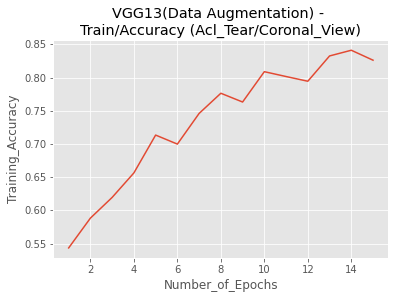

In [12]:
import matplotlib.pylab as plt

train_auc_lists = sorted(train_auc_dict.items()) # sorted by key, return a list of tuples
plt.style.use("ggplot")
plt.figure()
x, y = zip(*train_auc_lists) # unpack a list of pairs into two tuples
plt.xlabel("Number_of_Epochs")
plt.ylabel("Training_Accuracy")
plt.title("{}(Data Augmentation) - \nTrain/Accuracy ({}/{})".format(cnn_name,injury_name,mri_view.capitalize()+"_View"))
plt.plot(x, y)
#plt.savefig("VGG19(Data Augmentation) - Train/Accuracy (ACL_Tear/Sagittal_View).png")

plt.show()


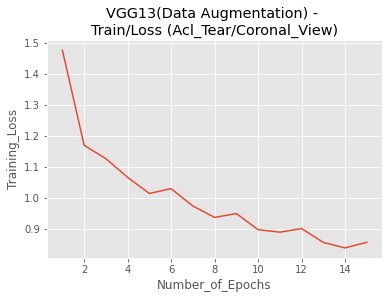

In [13]:
import matplotlib.pylab as plt

train_loss_lists = sorted(train_loss_dict.items()) # sorted by key, return a list of tuples
plt.style.use("ggplot")
plt.figure()
x, y = zip(*train_loss_lists) # unpack a list of pairs into two tuples
plt.xlabel("Number_of_Epochs")
plt.ylabel("Training_Loss")
plt.title("{}(Data Augmentation) - \nTrain/Loss ({}/{})".format(cnn_name,injury_name,mri_view.capitalize()+"_View"))
plt.plot(x, y)
#plt.savefig("VGG19(Data Augmentation) - Train/Loss (ACL_Tear/Sagittal_View).png")

plt.show()


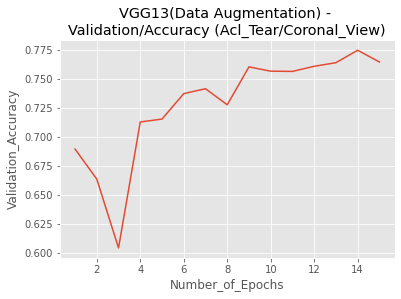

In [14]:
import matplotlib.pylab as plt

val_auc_lists = sorted(val_auc_dict.items()) # sorted by key, return a list of tuples
plt.style.use("ggplot")
plt.figure()
x, y = zip(*val_auc_lists) # unpack a list of pairs into two tuples
plt.xlabel("Number_of_Epochs")
plt.ylabel("Validation_Accuracy")
plt.title("{}(Data Augmentation) - \nValidation/Accuracy ({}/{})".format(cnn_name,injury_name,mri_view.capitalize()+"_View"))
plt.plot(x, y)
#plt.savefig("VGG19(Data Augmentation) - Validation/Accuracy (ACL_Tear/Sagittal_View).png")
plt.show()


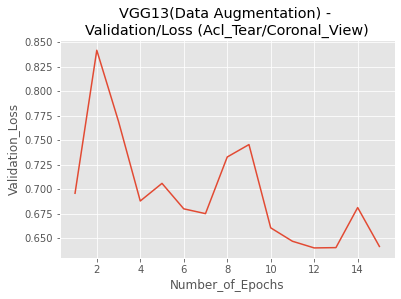

In [15]:
import matplotlib.pylab as plt

val_loss_lists = sorted(val_loss_dict.items()) # sorted by key, return a list of tuples
plt.style.use("ggplot")
plt.figure()
x, y = zip(*val_loss_lists) # unpack a list of pairs into two tuples
plt.xlabel("Number_of_Epochs")
plt.ylabel("Validation_Loss")
plt.title("{}(Data Augmentation) - \nValidation/Loss ({}/{})".format(cnn_name,injury_name,mri_view.capitalize()+"_View"))
plt.plot(x, y)
#plt.savefig("VGG19(Data Augmentation) - Validation/Loss (ACL_Tear/Sagittal_View).png")
plt.show()


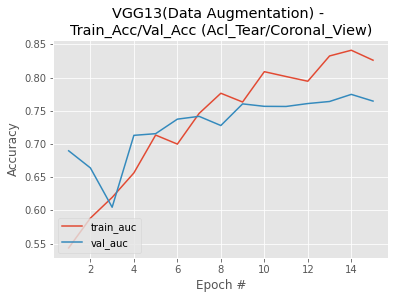

In [16]:
import matplotlib.pylab as plt

plt.style.use("ggplot")
plt.figure()
x, y = zip(*train_auc_lists)
x1, y1 = zip(*val_auc_lists)
plt.plot(x, y,label="train_auc")
plt.plot(x1, y1,label="val_auc")
# plt.title("VGG19(Data Augmentation) - \nTrain_Acc/Val_Acc (ACL_Tear/Sagittal_View)")
plt.title("{}(Data Augmentation) - \nTrain_Acc/Val_Acc ({}/{})".format(cnn_name,injury_name,mri_view.capitalize()+"_View"))
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

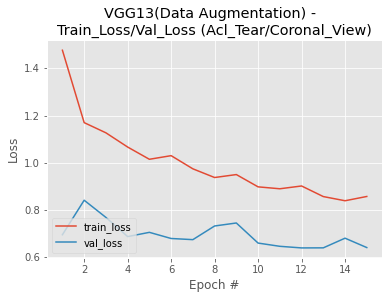

In [17]:
import matplotlib.pylab as plt

plt.style.use("ggplot")
plt.figure()
x, y = zip(*train_loss_lists)
x1, y1 = zip(*val_loss_lists)
plt.plot(x, y,label="train_loss")
plt.plot(x1, y1,label="val_loss")
# plt.title("VGG19(Data Augmentation) - \nTrain_Loss/Val_Loss (ACL_Tear/Sagittal_View)")
plt.title("{}(Data Augmentation) -  \nTrain_Loss/Val_Loss ({}/{})".format(cnn_name,injury_name,mri_view.capitalize()+"_View"))
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

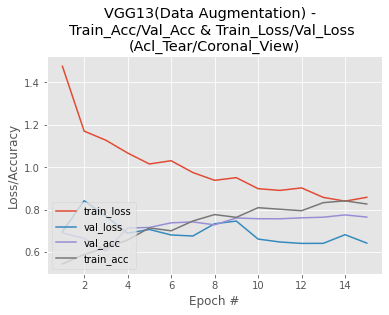

In [18]:
import matplotlib.pylab as plt

plt.style.use("ggplot")
plt.figure()
x, y = zip(*train_loss_lists)
x1, y1 = zip(*val_loss_lists)
x2, y2 = zip(*val_auc_lists)
x3, y3= zip(*train_auc_lists)
plt.plot(x, y,label="train_loss")
plt.plot(x1, y1,label="val_loss")
plt.plot(x2, y2,label="val_acc")
plt.plot(x3, y3,label="train_acc")
# plt.title("VGG19(Data Augmentation) - \nTrain_Acc/Val_Acc & Train_Loss/Val_Loss \n(ACL_Tear/Sagittal_View)")
plt.title("{}(Data Augmentation) -  \nTrain_Acc/Val_Acc & Train_Loss/Val_Loss \n({}/{})".format(cnn_name,injury_name,mri_view.capitalize()+"_View"))
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

#plt.savefig("VGG19(Data Augmentation) - Validation/Loss (ACL_Tear/Sagittal_View).png")
plt.show()